<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#하이퍼파라미터-세팅-및-seed-고정" data-toc-modified-id="하이퍼파라미터-세팅-및-seed-고정-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>하이퍼파라미터 세팅 및 seed 고정</a></span></li><li><span><a href="#학습-데이터-EDA" data-toc-modified-id="학습-데이터-EDA-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>학습 데이터 EDA</a></span></li><li><span><a href="#데이터-전처리-함수-정의-(Dataset)" data-toc-modified-id="데이터-전처리-함수-정의-(Dataset)-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>데이터 전처리 함수 정의 (Dataset)</a></span></li><li><span><a href="#Dataset-정의-및-DataLoader-할당" data-toc-modified-id="Dataset-정의-및-DataLoader-할당-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Dataset 정의 및 DataLoader 할당</a></span><ul class="toc-item"><li><span><a href="#데이터-샘플-시각화-(Show-example-image-and-mask)" data-toc-modified-id="데이터-샘플-시각화-(Show-example-image-and-mask)-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>데이터 샘플 시각화 (Show example image and mask)</a></span></li></ul></li><li><span><a href="#baseline-model" data-toc-modified-id="baseline-model-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>baseline model</a></span><ul class="toc-item"><li><span><a href="#[TODO]-코드-구현-DeepLabv2-" data-toc-modified-id="[TODO]-코드-구현-DeepLabv2--5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span><font color="red">[TODO] 코드 구현 DeepLabv2 </font></a></span></li></ul></li><li><span><a href="#train,-validation,-test-함수-정의" data-toc-modified-id="train,-validation,-test-함수-정의-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>train, validation, test 함수 정의</a></span></li><li><span><a href="#모델-저장-함수-정의" data-toc-modified-id="모델-저장-함수-정의-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>모델 저장 함수 정의</a></span></li><li><span><a href="#모델-생성-및-Loss-function,-Optimizer-정의" data-toc-modified-id="모델-생성-및-Loss-function,-Optimizer-정의-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>모델 생성 및 Loss function, Optimizer 정의</a></span></li><li><span><a href="#저장된-model-불러오기-(학습된-이후)" data-toc-modified-id="저장된-model-불러오기-(학습된-이후)-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>저장된 model 불러오기 (학습된 이후)</a></span></li><li><span><a href="#submission을-위한-test-함수-정의" data-toc-modified-id="submission을-위한-test-함수-정의-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>submission을 위한 test 함수 정의</a></span></li><li><span><a href="#submission.csv-생성" data-toc-modified-id="submission.csv-생성-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>submission.csv 생성</a></span></li><li><span><a href="#Reference" data-toc-modified-id="Reference-12"><span class="toc-item-num">12&nbsp;&nbsp;</span>Reference</a></span></li></ul></div>

In [1]:
import os
import random
import time
import json
import warnings 
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from utils import label_accuracy_score
import cv2

import numpy as np
import pandas as pd

# 전처리를 위한 라이브러리
from pycocotools.coco import COCO
import torchvision
import torchvision.transforms as transforms

import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm.notebook import tqdm

# 시각화를 위한 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

plt.rcParams['axes.grid'] = False

print('pytorch version: {}'.format(torch.__version__))
print('GPU 사용 가능 여부: {}'.format(torch.cuda.is_available()))

print(torch.cuda.get_device_name(0))
print(torch.cuda.device_count())

device = "cuda" if torch.cuda.is_available() else "cpu"   # GPU 사용 가능 여부에 따라 device 정보 저장

pytorch version: 1.4.0
GPU 사용 가능 여부: True
Tesla P40
1


## 하이퍼파라미터 세팅 및 seed 고정

In [2]:
batch_size = 8   # Mini-batch size
num_epochs = 8
learning_rate = 0.0001

In [3]:
# seed 고정
random_seed = 21
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
# torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

## 학습 데이터 EDA

In [4]:
%matplotlib inline

dataset_path = '/opt/ml/input/data'
anns_file_path = dataset_path + '/' + 'train.json'

# Read annotations
with open(anns_file_path, 'r') as f:
    dataset = json.loads(f.read())

categories = dataset['categories']
anns = dataset['annotations']
imgs = dataset['images']
nr_cats = len(categories)
nr_annotations = len(anns)
nr_images = len(imgs)

# Load categories and super categories
cat_names = []
super_cat_names = []
super_cat_ids = {}
super_cat_last_name = ''
nr_super_cats = 0
for cat_it in categories:
    cat_names.append(cat_it['name'])
    super_cat_name = cat_it['supercategory']
    # Adding new supercat
    if super_cat_name != super_cat_last_name:
        super_cat_names.append(super_cat_name)
        super_cat_ids[super_cat_name] = nr_super_cats
        super_cat_last_name = super_cat_name
        nr_super_cats += 1

print('Number of super categories:', nr_super_cats)
print('Number of categories:', nr_cats)
print('Number of annotations:', nr_annotations)
print('Number of images:', nr_images)

Number of super categories: 11
Number of categories: 11
Number of annotations: 21116
Number of images: 2617


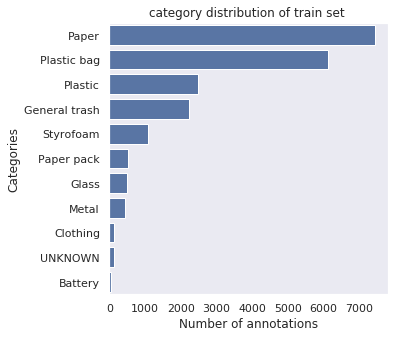

In [5]:
# Count annotations
cat_histogram = np.zeros(nr_cats,dtype=int)
for ann in anns:
    cat_histogram[ann['category_id']] += 1

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(5,5))

# Convert to DataFrame
df = pd.DataFrame({'Categories': cat_names, 'Number of annotations': cat_histogram})
df = df.sort_values('Number of annotations', 0, False)

# Plot the histogram
plt.title("category distribution of train set ")
plot_1 = sns.barplot(x="Number of annotations", y="Categories", data=df, label="Total", color="b")

In [6]:
# category labeling 
sorted_temp_df = df.sort_index()

# background = 0 에 해당되는 label 추가 후 기존들을 모두 label + 1 로 설정
sorted_df = pd.DataFrame(["Backgroud"], columns = ["Categories"])
sorted_df = sorted_df.append(sorted_temp_df, ignore_index=True)

In [7]:
# class (Categories) 에 따른 index 확인 (0~11 : 총 12개)
sorted_df

Categories  Number of annotations
0       Backgroud                    NaN
1         UNKNOWN                  128.0
2   General trash                 2225.0
3           Paper                 7448.0
4      Paper pack                  527.0
5           Metal                  449.0
6           Glass                  488.0
7         Plastic                 2472.0
8       Styrofoam                 1074.0
9     Plastic bag                 6114.0
10        Battery                   50.0
11       Clothing                  141.0

## 데이터 전처리 함수 정의 (Dataset)

In [8]:
category_names = list(sorted_df.Categories)

def get_classname(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"

class CustomDataLoader(Dataset):
    """COCO format"""
    def __init__(self, data_dir, mode = 'train', transform = None):
        super().__init__()
        self.mode = mode
        self.transform = transform
        self.coco = COCO(data_dir)
        
    def __getitem__(self, index: int):
        # dataset이 index되어 list처럼 동작
        image_id = self.coco.getImgIds(imgIds=index)
        image_infos = self.coco.loadImgs(image_id)[0]
        
        # cv2 를 활용하여 image 불러오기
        images = cv2.imread(os.path.join(dataset_path, image_infos['file_name']))
        images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB).astype(np.float32)
        images /= 255.0
        
        if (self.mode in ('train', 'val')):
            ann_ids = self.coco.getAnnIds(imgIds=image_infos['id'])
            anns = self.coco.loadAnns(ann_ids)

            # Load the categories in a variable
            cat_ids = self.coco.getCatIds()
            cats = self.coco.loadCats(cat_ids)

            # masks : size가 (height x width)인 2D
            # 각각의 pixel 값에는 "category id + 1" 할당
            # Background = 0
            masks = np.zeros((image_infos["height"], image_infos["width"]))
            # Unknown = 1, General trash = 2, ... , Cigarette = 11
            for i in range(len(anns)):
                className = get_classname(anns[i]['category_id'], cats)
                pixel_value = category_names.index(className)
                masks = np.maximum(self.coco.annToMask(anns[i])*pixel_value, masks)
            masks = masks.astype(np.float32)

            # transform -> albumentations 라이브러리 활용
            if self.transform is not None:
                transformed = self.transform(image=images, mask=masks)
                images = transformed["image"]
                masks = transformed["mask"]
            
            return images, masks, image_infos
        
        if self.mode == 'test':
            # transform -> albumentations 라이브러리 활용
            if self.transform is not None:
                transformed = self.transform(image=images)
                images = transformed["image"]
            
            return images, image_infos
    
    
    def __len__(self) -> int:
        # 전체 dataset의 size를 return
        return len(self.coco.getImgIds())

## Dataset 정의 및 DataLoader 할당

In [9]:
# train.json / validation.json / test.json 디렉토리 설정
train_path = dataset_path + '/train.json'
val_path = dataset_path + '/val.json'
test_path = dataset_path + '/test.json'

# collate_fn needs for batch
def collate_fn(batch):
    return tuple(zip(*batch))

train_transform = A.Compose([
                            ToTensorV2()
                            ])

val_transform = A.Compose([
                          ToTensorV2()
                          ])

test_transform = A.Compose([
                           ToTensorV2()
                           ])

# create own Dataset 1 (skip)
# validation set을 직접 나누고 싶은 경우
# random_split 사용하여 data set을 8:2 로 분할
# train_size = int(0.8*len(dataset))
# val_size = int(len(dataset)-train_size)
# dataset = CustomDataLoader(data_dir=train_path, mode='train', transform=transform)
# train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# create own Dataset 2
# train dataset
train_dataset = CustomDataLoader(data_dir=train_path, mode='train', transform=train_transform)

# validation dataset
val_dataset = CustomDataLoader(data_dir=val_path, mode='val', transform=val_transform)

# test dataset
test_dataset = CustomDataLoader(data_dir=test_path, mode='test', transform=test_transform)


# DataLoader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=4,
                                           collate_fn=collate_fn)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                         batch_size=batch_size,
                                         shuffle=False,
                                         num_workers=4,
                                         collate_fn=collate_fn)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          num_workers=4,
                                          collate_fn=collate_fn)

loading annotations into memory...
Done (t=3.75s)
creating index...
index created!
loading annotations into memory...
Done (t=0.77s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


### 데이터 샘플 시각화 (Show example image and mask)

- `train_loader` 
- `val_loader` 
- `test_loader` 

image shape: [3, 512, 512]
mask shape:  [512, 512]
Unique values, category of transformed mask : 
 [{0, 'Backgroud'}, {2, 'General trash'}, {'Paper', 3}]


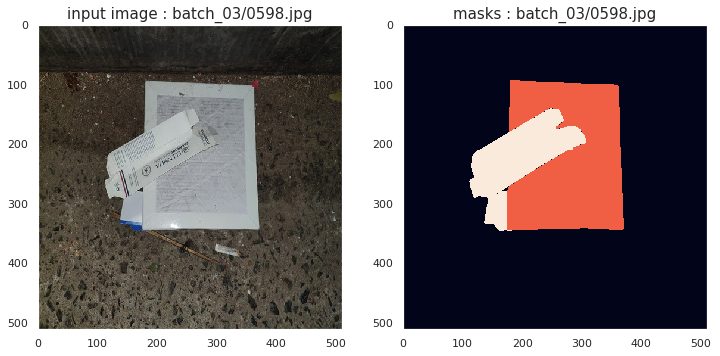

In [10]:
# train_loader의 output 결과(image 및 mask) 확인
for imgs, masks, image_infos in train_loader:
    image_infos = image_infos[0]
    temp_images = imgs
    temp_masks = masks
    
    break

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))

print('image shape:', list(temp_images[0].shape))
print('mask shape: ', list(temp_masks[0].shape))
print('Unique values, category of transformed mask : \n', [{int(i),category_names[int(i)]} for i in list(np.unique(temp_masks[0]))])

ax1.imshow(temp_images[0].permute([1,2,0]))
ax1.grid(False)
ax1.set_title("input image : {}".format(image_infos['file_name']), fontsize = 15)

ax2.imshow(temp_masks[0])
ax2.grid(False)
ax2.set_title("masks : {}".format(image_infos['file_name']), fontsize = 15)

plt.show()

image shape: [3, 512, 512]
mask shape:  [512, 512]
Unique values, category of transformed mask : 
 [{0, 'Backgroud'}, {'Glass', 6}, {'Plastic', 7}, {9, 'Plastic bag'}]


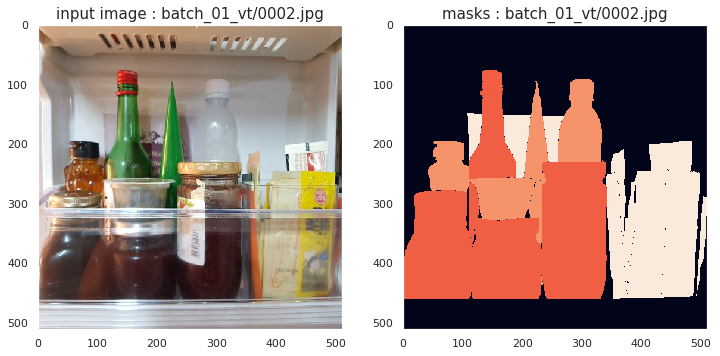

In [11]:
# val_loader의 output 결과(image 및 mask) 확인
for imgs, masks, image_infos in val_loader:
    image_infos = image_infos[0]
    temp_images = imgs
    temp_masks = masks
    
    break

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))

print('image shape:', list(temp_images[0].shape))
print('mask shape: ', list(temp_masks[0].shape))

print('Unique values, category of transformed mask : \n', [{int(i),category_names[int(i)]} for i in list(np.unique(temp_masks[0]))])

ax1.imshow(temp_images[0].permute([1,2,0]))
ax1.grid(False)
ax1.set_title("input image : {}".format(image_infos['file_name']), fontsize = 15)

ax2.imshow(temp_masks[0])
ax2.grid(False)
ax2.set_title("masks : {}".format(image_infos['file_name']), fontsize = 15)

plt.show()

image shape: [3, 512, 512]


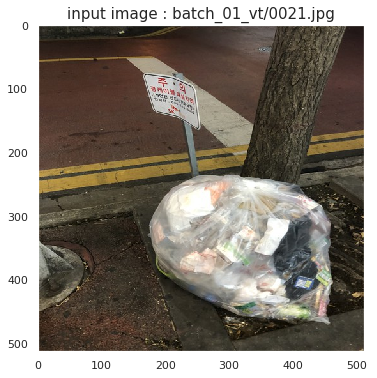

In [12]:
# test_loader의 output 결과(image 및 mask) 확인
for imgs, image_infos in test_loader:
    image_infos = image_infos[0]
    temp_images = imgs
    # temp_masks = masks
    
    break

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

print('image shape:', list(temp_images[0].shape))

ax1.imshow(temp_images[0].permute([1,2,0]))
ax1.grid(False)
ax1.set_title("input image : {}".format(image_infos['file_name']), fontsize = 15)

plt.show()

## baseline model

### VGG16 + DeepLavV2 구현

In [30]:
import torch
import torch.nn as nn
from torch.nn import functional as F

def conv3x3_relu(in_ch, out_ch, rate=1):
    conv3x3_relu = nn.Sequential(nn.Conv2d(in_ch, 
                                           out_ch, 
                                           kernel_size=3,
                                           stride=1,
                                           padding=rate,
                                           dilation=rate),
                                 nn.ReLU())
    return conv3x3_relu


class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        self.conv1 = nn.Sequential(
            conv3x3_relu(3, 64),
            conv3x3_relu(64, 64),
            nn.MaxPool2d(3, stride=2, padding=1) # 1/2
        )
        
        self.conv2 = nn.Sequential(
            conv3x3_relu(64, 128),
            conv3x3_relu(128, 128),
            nn.MaxPool2d(3, stride=2, padding=1) # 1/2 
        )
        
        self.conv3 = nn.Sequential(
            conv3x3_relu(128, 256),
            conv3x3_relu(256, 256),
            conv3x3_relu(256, 256),
            nn.MaxPool2d(3, stride=2, padding=1) # 1/2
        )
        
        self.conv4 = nn.Sequential(
            conv3x3_relu(256, 512),
            conv3x3_relu(512, 512),
            conv3x3_relu(512, 512),
            nn.MaxPool2d(3, stride=1, padding=1)
        )
        
        self.conv5 = nn.Sequential(
            conv3x3_relu(512, 512, rate=2),
            conv3x3_relu(512, 512, rate=2),
            conv3x3_relu(512, 512, rate=2),
            nn.MaxPool2d(3, stride=1, padding=1)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        
        return x

    
class ASPP(nn.Module):
    def __init__(self, in_channels, out_channels=1024, num_classes=21):
        super(ASPP, self).__init__()
        
        # rate = 6
        self.conv_3x3_r6 =  nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size  = 3, stride = 1, padding = 6, dilation = 6),
            nn.ReLU(),
            nn.Dropout2d(0.5),
            nn.Conv2d(out_channels, out_channels, kernel_size=1),
            nn.ReLU(),
            nn.Dropout2d(0.5),
            nn.Conv2d(out_channels, num_classes, kernel_size=1)
        )
        
        # rate = 12
        self.conv_3x3_r12 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size  = 3, stride = 1, padding = 12, dilation = 12),
            nn.ReLU(),
            nn.Dropout2d(0.5),
            nn.Conv2d(out_channels, out_channels, kernel_size=1),
            nn.ReLU(),
            nn.Dropout2d(0.5),
            nn.Conv2d(out_channels, num_classes, kernel_size=1)
        )
        
        # rate = 18
        self.conv_3x3_r18 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size  = 3, stride = 1, padding = 18, dilation = 18),
            nn.ReLU(),
            nn.Dropout2d(0.5),
            nn.Conv2d(out_channels, out_channels, kernel_size=1),
            nn.ReLU(),
            nn.Dropout2d(0.5),
            nn.Conv2d(out_channels, num_classes, kernel_size=1)
            
        )
        
        # rate = 24
        self.conv_3x3_r24 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size  = 3, stride = 1, padding = 24, dilation = 24),
            nn.ReLU(),
            nn.Dropout2d(0.5),
            nn.Conv2d(out_channels, out_channels, kernel_size=1),
            nn.ReLU(),
            nn.Dropout2d(0.5),
            nn.Conv2d(out_channels, num_classes, kernel_size=1)
        )
        
        

    def forward(self, feature_map):
        out_img_r6 = self.conv_3x3_r6(feature_map)
        out_img_r12 = self.conv_3x3_r12(feature_map)
        out_img_r18 = self.conv_3x3_r18(feature_map)
        out_img_r24 = self.conv_3x3_r24(feature_map)
        
        out = sum([out_img_r6, out_img_r12, out_img_r18, out_img_r24])
        
        return out

class DeepLabV2(nn.Module):
    ## VGG 위에 ASPP 쌓기
    def __init__(self, backbone, classifier, upsampling=8):
        super(DeepLabV2, self).__init__()
        self.backbone = backbone
        self.classifier = classifier
        self.upsampling = upsampling

    def forward(self, x):
        x = self.backbone(x)
        _, _, feature_map_h, feature_map_w = x.size()
        x = self.classifier(x)
        out = F.interpolate(x, size=(feature_map_h * self.upsampling, feature_map_w * self.upsampling), mode="bilinear")
        return out

In [31]:
# 구현된 model에 임의의 input을 넣어 output이 잘 나오는지 test
backbone = VGG16()
aspp_module = ASPP(in_channels=512, out_channels=256, num_classes = 12)
model = DeepLabV2(backbone=backbone, classifier=aspp_module)

x = torch.randn([1, 3, 512, 512])
print("input shape : ", x.shape)
out = model(x).to(device)
print("output shape : ", out.size())

model = model.to(device)

input shape :  torch.Size([1, 3, 512, 512])
output shape :  torch.Size([1, 12, 512, 512])


## train, validation, test 함수 정의

In [32]:
def train(num_epochs, model, data_loader, val_loader, criterion, optimizer, saved_dir, val_every, device):
    print('Start training..')
    best_loss = 9999999
    for epoch in range(num_epochs):
        model.train()
        for step, (images, masks, _) in enumerate(tqdm(data_loader)):
            images = torch.stack(images)       # (batch, channel, height, width)
            masks = torch.stack(masks).long()  # (batch, channel, height, width)
            
            # gpu 연산을 위해 device 할당
            images, masks = images.to(device), masks.to(device)
                  
            # inference
            outputs = model(images)
            
            # loss 계산 (cross entropy loss)
            loss = criterion(outputs, masks)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # step 주기에 따른 loss 출력
            if (step + 1) % 25 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(
                    epoch+1, num_epochs, step+1, len(train_loader), loss.item()))
        
        # validation 주기에 따른 loss 출력 및 best model 저장
        if (epoch + 1) % val_every == 0:
            avrg_loss = validation(epoch + 1, model, val_loader, criterion, device)
            if avrg_loss < best_loss:
                print('Best performance at epoch: {}'.format(epoch + 1))
                print('Save model in', saved_dir)
                best_loss = avrg_loss
                save_model(model, saved_dir)

In [33]:
def validation(epoch, model, data_loader, criterion, device):
    print('Start validation #{}'.format(epoch))
    model.eval()
    with torch.no_grad():
        total_loss = 0
        cnt = 0
        mIoU_list = []
        for step, (images, masks, _) in enumerate(tqdm(data_loader)):
            
            images = torch.stack(images)       # (batch, channel, height, width)
            masks = torch.stack(masks).long()  # (batch, channel, height, width)

            images, masks = images.to(device), masks.to(device)            

            outputs = model(images)
            loss = criterion(outputs, masks)
            total_loss += loss
            cnt += 1
            
            outputs = torch.argmax(outputs.squeeze(), dim=1).detach().cpu().numpy()

            mIoU = label_accuracy_score(masks.detach().cpu().numpy(), outputs, n_class=12)[2]
            mIoU_list.append(mIoU)
            
        avrg_loss = total_loss / cnt
        print('Validation #{}  Average Loss: {:.4f}, mIoU: {:.4f}'.format(epoch, avrg_loss, np.mean(mIoU_list)))

    return avrg_loss

## 모델 저장 함수 정의

In [34]:
# 모델 저장 함수 정의
val_every = 1 

saved_dir = './saved'
if not os.path.isdir(saved_dir):                                                           
    os.mkdir(saved_dir)
    
def save_model(model, saved_dir, file_name='DeepLabv2_best_model(pretrained).pt'):
    check_point = {'net': model.state_dict()}
    output_path = os.path.join(saved_dir, file_name)
    torch.save(model.state_dict(), output_path)

## 모델 생성 및 Loss function, Optimizer 정의

In [35]:
# Loss function 정의
criterion = nn.CrossEntropyLoss()

# Optimizer 정의
optimizer = torch.optim.Adam(params = model.parameters(), lr = learning_rate, weight_decay=1e-6)

In [36]:
train(num_epochs, model, train_loader, val_loader, criterion, optimizer, saved_dir, val_every, device)

Start training..


  0%|          | 0/328 [00:00<?, ?it/s]

Epoch [1/8], Step [25/328], Loss: 1.3310
Epoch [1/8], Step [50/328], Loss: 1.1451
Epoch [1/8], Step [75/328], Loss: 1.2588
Epoch [1/8], Step [100/328], Loss: 1.1750
Epoch [1/8], Step [125/328], Loss: 1.2770
Epoch [1/8], Step [150/328], Loss: 1.0211
Epoch [1/8], Step [175/328], Loss: 1.3289
Epoch [1/8], Step [200/328], Loss: 0.9370
Epoch [1/8], Step [225/328], Loss: 0.9650
Epoch [1/8], Step [250/328], Loss: 1.1337
Epoch [1/8], Step [275/328], Loss: 1.0322
Epoch [1/8], Step [300/328], Loss: 0.8842
Epoch [1/8], Step [325/328], Loss: 1.2670
Start validation #1


  0%|          | 0/82 [00:00<?, ?it/s]

Validation #1  Average Loss: 0.9548, mIoU: 0.1096
Best performance at epoch: 1
Save model in ./saved


  0%|          | 0/328 [00:00<?, ?it/s]

Epoch [2/8], Step [25/328], Loss: 0.9651
Epoch [2/8], Step [50/328], Loss: 0.7660
Epoch [2/8], Step [75/328], Loss: 1.0946
Epoch [2/8], Step [100/328], Loss: 0.8529
Epoch [2/8], Step [125/328], Loss: 0.9937
Epoch [2/8], Step [150/328], Loss: 1.0547
Epoch [2/8], Step [175/328], Loss: 0.9632
Epoch [2/8], Step [200/328], Loss: 0.7917
Epoch [2/8], Step [225/328], Loss: 1.2345
Epoch [2/8], Step [250/328], Loss: 1.0747
Epoch [2/8], Step [275/328], Loss: 1.1902
Epoch [2/8], Step [300/328], Loss: 0.5220
Epoch [2/8], Step [325/328], Loss: 0.9108
Start validation #2


  0%|          | 0/82 [00:00<?, ?it/s]

Validation #2  Average Loss: 0.9126, mIoU: 0.1251
Best performance at epoch: 2
Save model in ./saved


  0%|          | 0/328 [00:00<?, ?it/s]

Epoch [3/8], Step [25/328], Loss: 0.9509
Epoch [3/8], Step [50/328], Loss: 1.2788
Epoch [3/8], Step [75/328], Loss: 0.8848
Epoch [3/8], Step [100/328], Loss: 1.1152
Epoch [3/8], Step [125/328], Loss: 1.2149
Epoch [3/8], Step [150/328], Loss: 0.9142
Epoch [3/8], Step [175/328], Loss: 1.3681
Epoch [3/8], Step [200/328], Loss: 1.1277
Epoch [3/8], Step [225/328], Loss: 0.8261
Epoch [3/8], Step [250/328], Loss: 1.2074
Epoch [3/8], Step [275/328], Loss: 0.7660
Epoch [3/8], Step [300/328], Loss: 1.2970
Epoch [3/8], Step [325/328], Loss: 0.9797
Start validation #3


  0%|          | 0/82 [00:00<?, ?it/s]

Validation #3  Average Loss: 0.8976, mIoU: 0.1312
Best performance at epoch: 3
Save model in ./saved


  0%|          | 0/328 [00:00<?, ?it/s]

Epoch [4/8], Step [25/328], Loss: 1.0129
Epoch [4/8], Step [50/328], Loss: 0.8782
Epoch [4/8], Step [75/328], Loss: 0.8007
Epoch [4/8], Step [100/328], Loss: 0.8409
Epoch [4/8], Step [125/328], Loss: 0.9305
Epoch [4/8], Step [150/328], Loss: 0.7086
Epoch [4/8], Step [175/328], Loss: 1.1541
Epoch [4/8], Step [200/328], Loss: 1.0499
Epoch [4/8], Step [225/328], Loss: 0.8016
Epoch [4/8], Step [250/328], Loss: 0.7184
Epoch [4/8], Step [275/328], Loss: 0.9223
Epoch [4/8], Step [300/328], Loss: 1.0021
Epoch [4/8], Step [325/328], Loss: 1.0199
Start validation #4


  0%|          | 0/82 [00:00<?, ?it/s]

Validation #4  Average Loss: 0.8331, mIoU: 0.1447
Best performance at epoch: 4
Save model in ./saved


  0%|          | 0/328 [00:00<?, ?it/s]

Epoch [5/8], Step [25/328], Loss: 0.9184
Epoch [5/8], Step [50/328], Loss: 0.6120
Epoch [5/8], Step [75/328], Loss: 0.9788
Epoch [5/8], Step [100/328], Loss: 0.8300
Epoch [5/8], Step [125/328], Loss: 0.8933
Epoch [5/8], Step [150/328], Loss: 0.6928
Epoch [5/8], Step [175/328], Loss: 0.8001
Epoch [5/8], Step [200/328], Loss: 0.8882
Epoch [5/8], Step [225/328], Loss: 0.7653
Epoch [5/8], Step [250/328], Loss: 0.8171
Epoch [5/8], Step [275/328], Loss: 0.9636
Epoch [5/8], Step [300/328], Loss: 0.5117
Epoch [5/8], Step [325/328], Loss: 1.3455
Start validation #5


  0%|          | 0/82 [00:00<?, ?it/s]

Validation #5  Average Loss: 0.8048, mIoU: 0.1589
Best performance at epoch: 5
Save model in ./saved


  0%|          | 0/328 [00:00<?, ?it/s]

Epoch [6/8], Step [25/328], Loss: 0.6637
Epoch [6/8], Step [50/328], Loss: 0.8540
Epoch [6/8], Step [75/328], Loss: 0.7868
Epoch [6/8], Step [100/328], Loss: 0.5822
Epoch [6/8], Step [125/328], Loss: 0.5463
Epoch [6/8], Step [150/328], Loss: 0.4898
Epoch [6/8], Step [175/328], Loss: 0.5520
Epoch [6/8], Step [200/328], Loss: 0.7666
Epoch [6/8], Step [225/328], Loss: 0.6386
Epoch [6/8], Step [250/328], Loss: 0.7751
Epoch [6/8], Step [275/328], Loss: 0.7752
Epoch [6/8], Step [300/328], Loss: 0.7569
Epoch [6/8], Step [325/328], Loss: 0.8476
Start validation #6


  0%|          | 0/82 [00:00<?, ?it/s]

Validation #6  Average Loss: 0.8136, mIoU: 0.1524


  0%|          | 0/328 [00:00<?, ?it/s]

Epoch [7/8], Step [25/328], Loss: 0.6125
Epoch [7/8], Step [50/328], Loss: 0.8488
Epoch [7/8], Step [75/328], Loss: 0.5571
Epoch [7/8], Step [100/328], Loss: 1.0164
Epoch [7/8], Step [125/328], Loss: 0.8233
Epoch [7/8], Step [150/328], Loss: 0.9821
Epoch [7/8], Step [175/328], Loss: 1.5236
Epoch [7/8], Step [200/328], Loss: 1.2291
Epoch [7/8], Step [225/328], Loss: 0.7501
Epoch [7/8], Step [250/328], Loss: 0.8268
Epoch [7/8], Step [275/328], Loss: 0.8060
Epoch [7/8], Step [300/328], Loss: 0.6025
Epoch [7/8], Step [325/328], Loss: 0.5560
Start validation #7


  0%|          | 0/82 [00:00<?, ?it/s]

Validation #7  Average Loss: 0.7919, mIoU: 0.1664
Best performance at epoch: 7
Save model in ./saved


  0%|          | 0/328 [00:00<?, ?it/s]

Epoch [8/8], Step [25/328], Loss: 0.6013
Epoch [8/8], Step [50/328], Loss: 0.7319
Epoch [8/8], Step [75/328], Loss: 0.5834
Epoch [8/8], Step [100/328], Loss: 0.6726
Epoch [8/8], Step [125/328], Loss: 0.5344
Epoch [8/8], Step [150/328], Loss: 0.6826
Epoch [8/8], Step [175/328], Loss: 1.0943
Epoch [8/8], Step [200/328], Loss: 0.8316
Epoch [8/8], Step [225/328], Loss: 1.0551
Epoch [8/8], Step [250/328], Loss: 0.7933
Epoch [8/8], Step [275/328], Loss: 0.7751
Epoch [8/8], Step [300/328], Loss: 0.7318
Epoch [8/8], Step [325/328], Loss: 0.6028
Start validation #8


  0%|          | 0/82 [00:00<?, ?it/s]

Validation #8  Average Loss: 0.7836, mIoU: 0.1676
Best performance at epoch: 8
Save model in ./saved


## 저장된 model 불러오기 (학습된 이후) 

In [37]:
# best model 저장된 경로
model_path = './saved/DeepLabv2_best_model(pretrained).pt'

# best model 불러오기
checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint)

# 추론을 실행하기 전에는 반드시 설정 (batch normalization, dropout 를 평가 모드로 설정)
# model.eval()

<All keys matched successfully>

Shape of Original Image : [3, 512, 512]
Shape of Predicted :  [512, 512]
Unique values, category of transformed mask : 
 [{0, 'Backgroud'}, {'Paper', 3}, {9, 'Plastic bag'}]


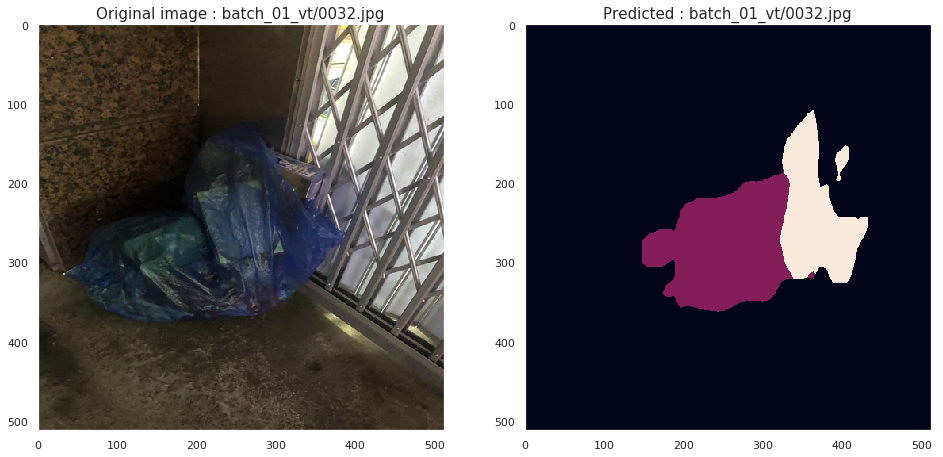

In [38]:
# 첫번째 batch의 추론 결과 확인
for imgs, image_infos in test_loader:
    image_infos = image_infos
    temp_images = imgs
    
    model.eval()
    # inference
    outs = model(torch.stack(temp_images).to(device))
    oms = torch.argmax(outs.squeeze(), dim=1).detach().cpu().numpy()
    
    break

i = 3
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 16))

print('Shape of Original Image :', list(temp_images[i].shape))
print('Shape of Predicted : ', list(oms[i].shape))
print('Unique values, category of transformed mask : \n', [{int(i),category_names[int(i)]} for i in list(np.unique(oms[i]))])

# Original image
ax1.imshow(temp_images[i].permute([1,2,0]))
ax1.grid(False)
ax1.set_title("Original image : {}".format(image_infos[i]['file_name']), fontsize = 15)

# Predicted
ax2.imshow(oms[i])
ax2.grid(False)
ax2.set_title("Predicted : {}".format(image_infos[i]['file_name']), fontsize = 15)

plt.show()

## submission을 위한 test 함수 정의

In [41]:
def test(model, data_loader, device):
    size = 256
    transform = A.Compose([A.Resize(256, 256)])
    print('Start prediction.')
    model.eval()
    
    file_name_list = []
    preds_array = np.empty((0, size*size), dtype=np.long)
    
    with torch.no_grad():
        for step, (imgs, image_infos) in enumerate(tqdm(test_loader)):

            # inference (512 x 512)
            outs = model(torch.stack(imgs).to(device))
            oms = torch.argmax(outs.squeeze(), dim=1).detach().cpu().numpy()
            
            # resize (256 x 256)
            temp_mask = []
            for img, mask in zip(np.stack(temp_images), oms):
                transformed = transform(image=img, mask=mask)
                mask = transformed['mask']
                temp_mask.append(mask)

            oms = np.array(temp_mask)
            
            oms = oms.reshape([oms.shape[0], size*size]).astype(int)
            preds_array = np.vstack((preds_array, oms))
            
            file_name_list.append([i['file_name'] for i in image_infos])
    print("End prediction.")
    file_names = [y for x in file_name_list for y in x]
    
    return file_names, preds_array

## submission.csv 생성

In [42]:
# sample_submisson.csv 열기
submission = pd.read_csv('./submission/sample_submission.csv', index_col=None)

# test set에 대한 prediction
file_names, preds = test(model, test_loader, device)

# PredictionString 대입
for file_name, string in zip(file_names, preds):
    submission = submission.append({"image_id" : file_name, "PredictionString" : ' '.join(str(e) for e in string.tolist())}, 
                                   ignore_index=True)

# submission.csv로 저장
submission.to_csv("./submission/Baseline_DeepLabv2.csv", index=False)

Start prediction.


  0%|          | 0/105 [00:00<?, ?it/s]

End prediction.


## Reference

